In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Loading dataset

In [2]:
(trainX, trainy), (testX, testy) = load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


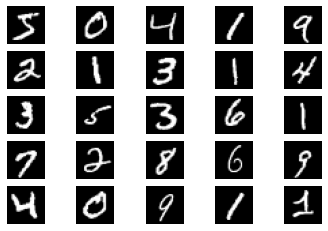

In [3]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i], cmap='gray')

# Implement Conditional GAN

## Discriminator 

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):

    # label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)

    n_nodes = in_shape[0] * in_shape[1]

    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # image input
    in_image = Input(shape=in_shape)

    # concat label as a channel
    merge = Concatenate()([in_image, li])

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)

    model = Model([in_image, in_label], out_layer)

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

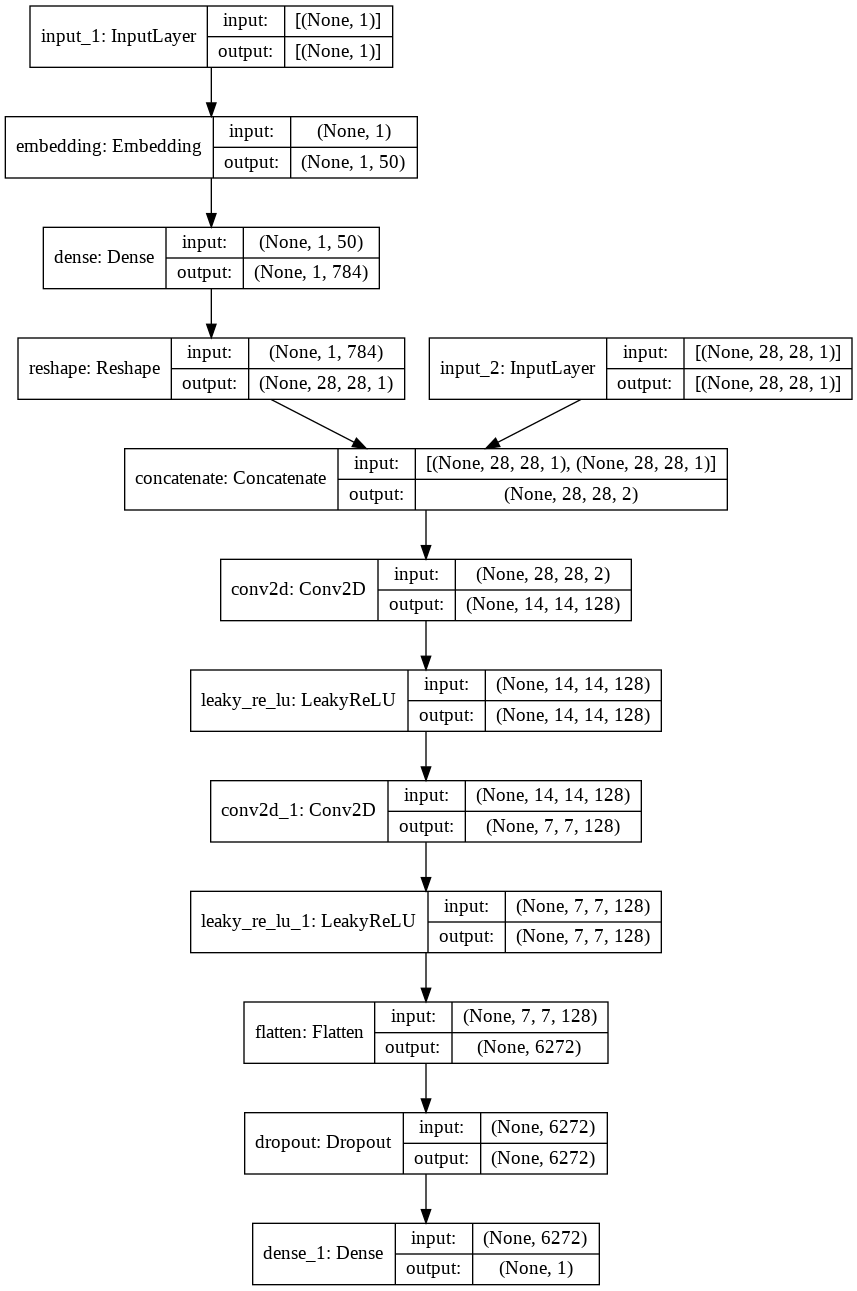

In [5]:
demo_discriminator = define_discriminator()
# Plot model
tf.keras.utils.plot_model(demo_discriminator, show_shapes=True, show_layer_names=True)

# Generator model

In [6]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    
    # label input
    in_label = Input(shape=(1,))
    
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

    model = Model([in_lat, in_label], out_layer)
    return model

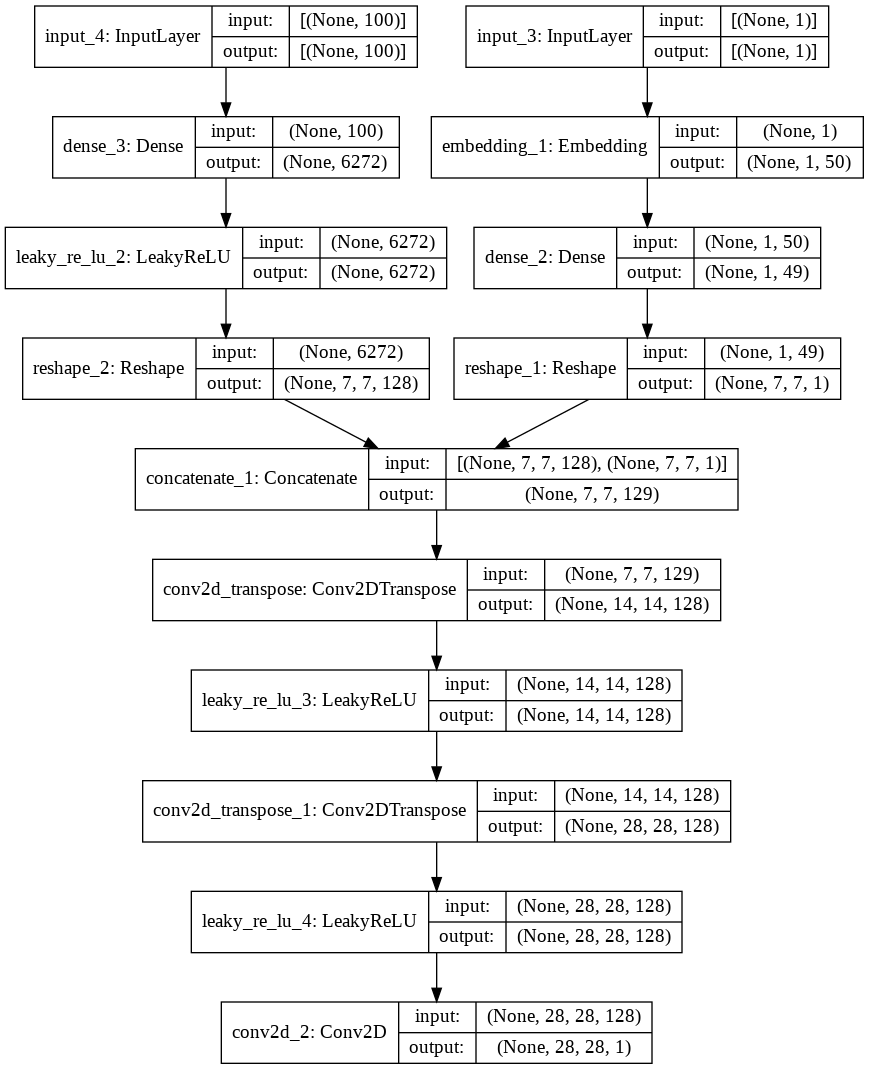

In [7]:
demo_discriminator = define_generator(latent_dim=100)
# Plot model
tf.keras.utils.plot_model(demo_discriminator, show_shapes=True, show_layer_names=True)

# GAN

In [8]:
def define_gan(g_model, d_model):

    d_model.trainable = False

    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input

    # get image output from the generator model
    gen_output = g_model.output

    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    
    # define gan model as taking noise and label and outputting a classification
    gan = Model([gen_noise, gen_label], gan_output)    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    
    return gan

# Training process

In [9]:
# Load MNIST dataset
def load_real_samples():

    (trainX, trainy), (testX, testy) = load_data()

    X = np.concatenate([trainX, testX])
    y = np.concatenate([trainy, testy])

    X = np.expand_dims(trainX, axis=-1)
    X = (X.astype("float") - 127.5) / 127.5

    return [X, y]

# select real samples
def generate_real_samples(dataset, n_samples):
	
    # split into images and labels
    images, labels = dataset

    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)

    # select images and labels
    X, labels = images[ix], labels[ix]

    # generate class labels
    y = np.ones((n_samples, 1))

    return [X, labels], y

In [10]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)

    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)

    return [z_input, labels]

# generator generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    # predict outputs
    images = generator.predict([z_input, labels_input])

    # create class labels
    y = np.zeros((n_samples, 1))

    return [images, labels_input], y

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
	
    for i in range(n_epochs):

        for j in range(bat_per_epo):

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            y_gan = np.ones((n_batch, 1))

            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

        print('> %d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

    # save the generator model
    g_model.save('cgan_generator.h5')

In [12]:
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)

> 1, d1=0.001, d2=0.001 g=7.605
> 2, d1=0.000, d2=0.000 g=9.373
> 3, d1=0.000, d2=0.000 g=11.189
> 4, d1=0.000, d2=0.000 g=11.689
> 5, d1=0.000, d2=0.000 g=12.072
> 6, d1=0.000, d2=0.000 g=13.489
> 7, d1=0.309, d2=0.377 g=1.613
> 8, d1=0.724, d2=0.765 g=0.760
> 9, d1=0.552, d2=0.557 g=1.029
> 10, d1=0.759, d2=0.498 g=0.977
> 11, d1=0.571, d2=0.667 g=0.872
> 12, d1=0.605, d2=0.608 g=0.850
> 13, d1=0.626, d2=0.865 g=0.796
> 14, d1=0.626, d2=0.704 g=0.841
> 15, d1=0.633, d2=0.617 g=0.980
> 16, d1=0.681, d2=0.556 g=1.006
> 17, d1=0.666, d2=0.620 g=0.938
> 18, d1=0.658, d2=0.555 g=0.987
> 19, d1=0.681, d2=0.670 g=0.917
> 20, d1=0.683, d2=0.660 g=0.874


# Generate Number using CGAN

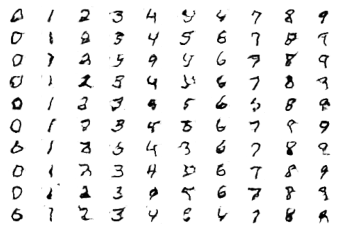

In [14]:
# create and save a plot of generated images
def save_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)

# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])

# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

- The result is not perfect. The result can be more realistic when we training with higher epochs (50 epochs)